# TF2 Example with new NFP layers

In [1]:
import nfp
import tensorflow as tf

# I typically run this on shared GPU resources, so I limit memory growth.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


In [2]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

### Load the solubility dataset and split into train / test / valid sets

In [3]:
solubility = pd.read_csv('../data/delaney.csv')

# Split into train, dev, and test sets
train = solubility.sample(frac=.8, random_state=1)
valid = solubility[~solubility.index.isin(train.index)].sample(frac=.5, random_state=1)
test = solubility[~solubility.index.isin(train.index) & ~solubility.index.isin(valid.index)]

### Create the preprocessor
and define an iterator to yield input encodings and prediction targets

In [4]:
preprocessor = nfp.SmilesPreprocessor()
        
def inputs_generator(df, train=True):
    for i, row in tqdm(df.iterrows()):
        input_dict = preprocessor.construct_feature_matrices(row.smiles, train=train)
        input_dict['solubility'] = row['measured log solubility in mols per litre']
        
        features = {key: nfp.serialize_value(val) for key, val in input_dict.items()}
        example_proto = tf.train.Example(features=tf.train.Features(feature=features))
        
        yield example_proto.SerializeToString()

### TFRecords preprocessing
I'm using the tfrecords file format to write the preprocessed train and validation inputs to disk.

This allows me to take a full pass over the training dataset to learn atom / bond types before looking at the validation set

In [5]:
# Preprocess and write the train dataset to disk
serialized_train_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(train, train=True),
    output_types=tf.string, output_shapes=())

filename = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_train_dataset)

# Preprocess and write the validation dataset to disk
serialized_valid_dataset = tf.data.Dataset.from_generator(
    lambda: inputs_generator(valid, train=False),
    output_types=tf.string, output_shapes=())

filename = 'valid.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_valid_dataset)

902it [00:01, 699.22it/s]
113it [00:00, 783.72it/s]


In [6]:
preprocessor.max_atoms

119

In [7]:
preprocessor.max_bonds

126

### Load the dataset back from the tfrecord files
These functions load the saved data back from the disk, and batches and pads the resulting inputs.

TF's tfrecord format asks for some fairly verbose descriptions of the data types.

In [8]:
def parse_example(example):
    
    parsed = tf.io.parse_single_example(example, features={
        **preprocessor.tfrecord_features,
        **{'solubility': tf.io.FixedLenFeature([], dtype=tf.float32)}})

    # All of the array preprocessor features are serialized integer arrays
    for key, val in preprocessor.tfrecord_features.items():
        if val.dtype == tf.string:
            parsed[key] = tf.io.parse_tensor(
                parsed[key], out_type=preprocessor.output_types[key])
    
    # Pop out the prediction target from the stored dictionary as a seperate input
    solubility = parsed.pop('solubility')
    
    return parsed, solubility

max_atoms = -1  # These allow prespecifying array shapes, i.e. for CUDA cores
max_bonds = -1

# Here, we have to add the prediction target padding onto the input padding
padded_shapes = (preprocessor.padded_shapes(max_atoms=max_atoms, max_bonds=max_bonds),
                 [])

# In case there's not enough molecules in a batch, solubility would be padded with NaNs
padding_values = (preprocessor.padding_values,
                  tf.constant(np.nan, dtype=tf.float32))

batch_size = 2**6

train_dataset = tf.data.TFRecordDataset('train.tfrecord')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .cache().repeat().shuffle(buffer_size=500)\
    .padded_batch(batch_size=batch_size,
                  padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.TFRecordDataset('valid.tfrecord')\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .cache().repeat().shuffle(buffer_size=500)\
    .padded_batch(batch_size=batch_size,
                  padded_shapes=padded_shapes,
                  padding_values=padding_values)\
    .prefetch(tf.data.experimental.AUTOTUNE)

### Define the tf.keras model

Here's where I actually define the keras model. The new NFP layers are fairly basic 'Gather', 'Slice', and 'Reduce' layers, that I compose into these graph neural networks. They're a bit less fully-featured, but a lot more flexible for different architectures.

In [9]:
from tensorflow.keras import layers
import nfp

n_atom = layers.Input(shape=[], dtype=tf.int64, name='n_atom')
n_bond = layers.Input(shape=[], dtype=tf.int64, name='n_bond')
bond_indices = layers.Input(shape=[None], dtype=tf.int64, name='bond_indices')
atom_class = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond_class = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

input_tensors = [n_atom, n_bond, bond_indices, atom_class, bond_class, connectivity]

atom_features = 16
num_messages = 3

# Initialize the atom states
atom_state = layers.Embedding(preprocessor.atom_classes, atom_features,
                              name='atom_embedding', mask_zero=True)(atom_class)

# Initialize the bond states
bond_state = layers.Embedding(preprocessor.bond_classes, atom_features,
                              name='bond_embedding', mask_zero=True)(bond_class)

# Initialize the bond states
atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom_class)


def message_block(original_atom_state, original_bond_state, connectivity, i):
    
    atom_state = layers.LayerNormalization()(original_atom_state)
    bond_state = layers.LayerNormalization()(original_bond_state)
    
    source_atom = nfp.Gather()([atom_state, nfp.Slice(np.s_[:, :, 1])(connectivity)])
    target_atom = nfp.Gather()([atom_state, nfp.Slice(np.s_[:, :, 0])(connectivity)])

    # Edge update network
    new_bond_state = layers.Concatenate(name='concat_{}'.format(i))(
        [source_atom, target_atom, bond_state])
    new_bond_state = layers.Dense(
        2*atom_features, activation='relu')(new_bond_state)
    new_bond_state = layers.Dense(atom_features)(new_bond_state)

    bond_state = layers.Add()([original_bond_state, new_bond_state])

    # message function
    source_atom = layers.Dense(atom_features)(source_atom)    
    messages = layers.Multiply()([source_atom, bond_state])
    messages = nfp.Reduce(reduction='sum')(
        [messages, nfp.Slice(np.s_[:, :, 0])(connectivity), atom_state])
    
    # state transition function
    messages = layers.Dense(atom_features, activation='relu')(messages)
    messages = layers.Dense(atom_features)(messages)
    
    atom_state = layers.Add()([original_atom_state, messages])
    
    return atom_state, bond_state

for i in range(num_messages):
    atom_state, bond_state = message_block(atom_state, bond_state, connectivity, i)
    
atom_state = layers.Dense(1)(atom_state)
atom_state = layers.Add()([atom_state, atom_mean])

averaged_solubility = tf.keras.layers.GlobalAveragePooling1D()(atom_state)

model = tf.keras.Model(input_tensors, [averaged_solubility])
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(3E-4))

In [10]:
hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                 steps_per_epoch=len(train) // batch_size,
                 validation_steps=len(valid) // batch_size, verbose=2)

Train for 14 steps, validate for 1 steps
Epoch 1/50
14/14 - 7s - loss: 1.8274 - val_loss: 1.3314
Epoch 2/50
14/14 - 0s - loss: 1.4596 - val_loss: 1.4011
Epoch 3/50
14/14 - 0s - loss: 1.3129 - val_loss: 1.2760
Epoch 4/50
14/14 - 0s - loss: 1.2414 - val_loss: 1.2442
Epoch 5/50
14/14 - 0s - loss: 1.2785 - val_loss: 1.2193
Epoch 6/50
14/14 - 0s - loss: 1.1348 - val_loss: 0.9977
Epoch 7/50
14/14 - 0s - loss: 1.0366 - val_loss: 1.0713
Epoch 8/50
14/14 - 0s - loss: 1.0610 - val_loss: 0.9232
Epoch 9/50
14/14 - 0s - loss: 0.9887 - val_loss: 0.8516
Epoch 10/50
14/14 - 0s - loss: 0.9692 - val_loss: 1.0032
Epoch 11/50
14/14 - 0s - loss: 0.9197 - val_loss: 0.8699
Epoch 12/50
14/14 - 0s - loss: 0.8665 - val_loss: 0.6660
Epoch 13/50
14/14 - 0s - loss: 0.8646 - val_loss: 0.8221
Epoch 14/50
14/14 - 0s - loss: 0.8414 - val_loss: 0.7536
Epoch 15/50
14/14 - 0s - loss: 0.7774 - val_loss: 0.7750
Epoch 16/50
14/14 - 0s - loss: 0.8591 - val_loss: 0.8122
Epoch 17/50
14/14 - 0s - loss: 0.7840 - val_loss: 0.6652

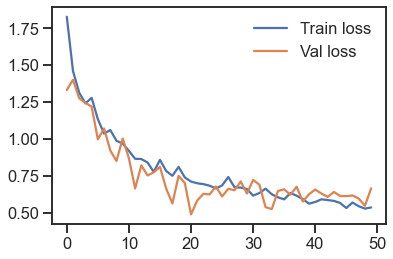

In [11]:
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Val loss')
plt.legend()

### Model predictions

Here I simulate wanting to re-load a trained model in another script. This saves both the preprocessor (for remembering how to convert atoms and bonds to their classes) as well as the trained model weights and structure.

In [12]:
model.save('model.h5')

import pickle
with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [13]:
# Just to show these are created again
del model
del preprocessor

In [14]:
model = tf.keras.models.load_model('model.h5', custom_objects=nfp.custom_objects)
with open('preprocessor.p', 'rb') as f:
    preprocessor = pickle.load(f)

Here I show a slightly different dataset approach that doesn't use TFRecords, in case this is done for interactive predictions of new molecules where round-tripping a binary file doesn't make sense

In [20]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=batch_size,
                  padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [21]:
predictions = model.predict(test_dataset)

Text(0.5, 1.0, 'Test MAE: 0.689')

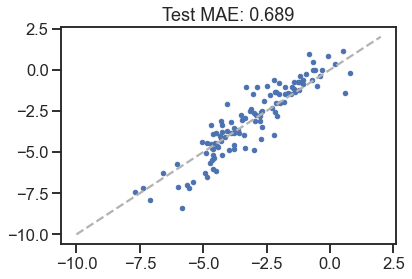

In [22]:
plt.plot(predictions, test['measured log solubility in mols per litre'], '.')
plt.plot([-10, 2], [-10, 2], '--', color='.7')
mae = (predictions.squeeze() - test['measured log solubility in mols per litre']).abs().mean()
plt.title(f'Test MAE: {mae:.3f}')